# Section 8

In [1]:
using Plots
gr()
using LaTeXStrings

newaxis = [CartesianIndex()]

using FFTW
using TensorOperations # Einsum

In [2]:
#using Revise
using SparseIR
import SparseIR: cond

## Step 1: Generate IR basis and associated sampling points

In [3]:
lambda_ = 1e+5
beta = 1e+3
eps = 1e-7
# Number of divisions along each reciprocal lattice vector
# Note: For a smaller nk (e.g., 64), an unphysical small structures appear in the self-energy at low frequencies.
nk_lin = 256
#nk_lin = 16
U = 2.0 # Onsite repulsion

wmax = lambda_/beta
basis = FiniteTempBasis(fermion, beta, wmax, eps)
L = length(basis)

# Sparse sampling in tau
smpl_tau = TauSampling(basis)
ntau = length(smpl_tau.sampling_points)
println("cond (tau): ", cond(smpl_tau))

# Sparse sampling in Matsubara frequencies
smpl_matsu = MatsubaraSampling(basis)
nw = length(smpl_matsu.sampling_points)
println("cond (matsu): ", cond(smpl_matsu))

cond (tau): 178.7075716170517
cond (matsu): 248.85153711180217


## Step 2
Compute the non-interacting Green's function on a mesh

In [4]:
kps = (nk_lin, nk_lin)
nk = prod(kps)
nr = nk

ek = zeros(Float64, kps...) # Equivalent to zeros(Float64, kps[1], kps[2])
for k2 in 1:nk_lin, k1 in 1:nk_lin
   ek[k1, k2] = -2 * (cos(2*π*k1/nk_lin) + cos(2*π*k2/nk_lin))
end

## Step 2
Compute non-interacting Green's function on sampling frequencies

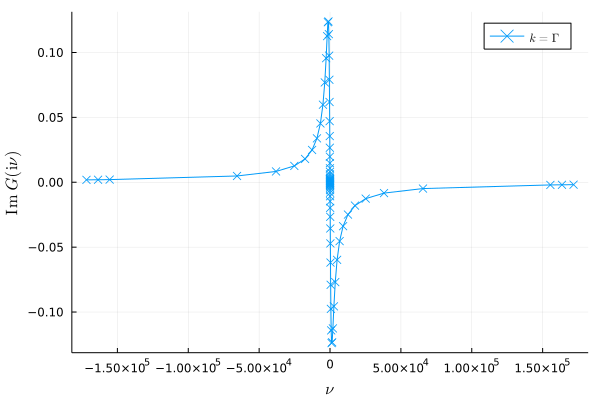

In [5]:
iv = (im * π/beta) * smpl_matsu.sampling_points
gkf = 1.0 ./ (iv[:,newaxis] .- vec(ek)[newaxis,:])

plot(smpl_matsu.sampling_points, imag(gkf[:,1]), label=latexstring("k=\\Gamma"),
    marker=:x, xlabel=latexstring("\\nu"), ylabel=latexstring("\\mathrm{Im}~G(\\mathrm{i}\\nu)"))

## Step 3
Evaluate the Green's function on sampling points in the imaginary-time domain

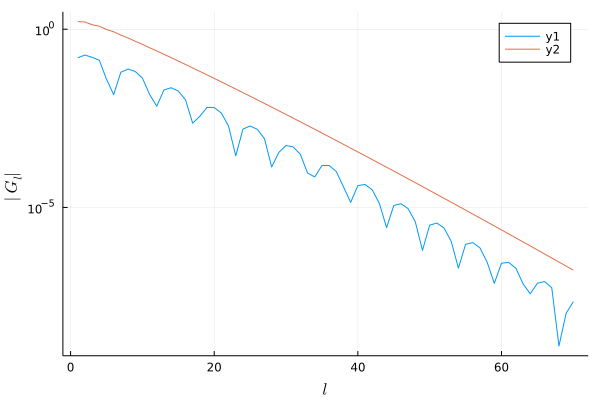

In [6]:
# G(l, k): (L, nk)
gkl = fit(smpl_matsu, gkf, dim=1)
@assert size(gkl) == (L, nk)

plot([abs.(gkl[:,1]), basis.s], xlabel=latexstring("l"), ylabel=latexstring("|G_l|"), yaxis=:log)

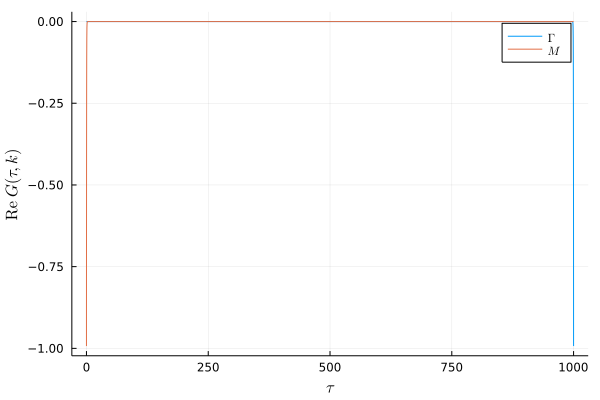

In [7]:
gkt = evaluate(smpl_tau, gkl, dim=1)

@assert size(gkt) == (ntau, nk)

plot(
    smpl_tau.sampling_points, [real(gkt[:,1]), reshape(real(gkt), ntau, kps...)[:,nk_lin÷2+1,nk_lin÷2+1]],
    label=[latexstring("\\Gamma") latexstring("M")],
    xlabel=latexstring("\\tau"),
    ylabel=latexstring("\\mathrm{Re}~G(\\tau, k)"),
)

## Step 4
Transform the Green's function to the real space and evaluate the self-energy

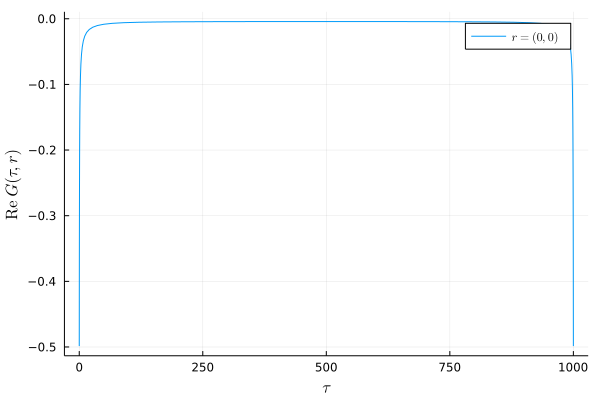

In [8]:
# Compute G(tau, r): (ntau, nk)
#  (1) Reshape gkt into shape of (ntau, nk_lin, nk_lin).
#  (2) Apply FFT to the axes 1, 2.
#  (3) Reshape the result to (ntau, nk)
# G(tau, k): (ntau, nk)
grt = fft(reshape(gkt, ntau, kps...), [2,3])
grt = reshape(grt, ntau, nk)/nk

plot(smpl_tau.sampling_points, real(grt[:,1]), label=latexstring("r=(0,0)"), xlabel=latexstring("\\tau"), ylabel=latexstring("\\mathrm{Re}~G(\\tau, r)"))

Compute the second-order term of the self-energy on the sampling points

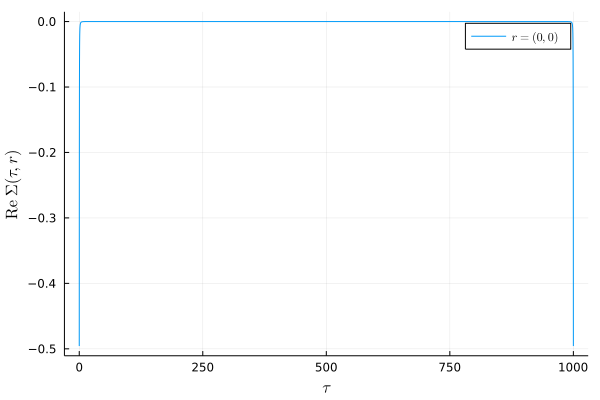

In [9]:
# Sigma(tau, r): (ntau, nr)
# srt = (U*U) * (grt .* grt .* reverse(grt, dims=1))
srt = Array{Complex{Float64}}(undef, ntau, nr)
for ir=1:nr, itau=1:ntau
    srt[itau, ir] = (U*U) * (grt[itau, ir]^2) *  grt[ntau-itau+1, ir]
end

plot(
    smpl_tau.sampling_points, real(srt[:,1]), label=latexstring("r=(0,0)"), xlabel=latexstring("\\tau"), ylabel=latexstring("\\mathrm{Re}~\\Sigma(\\tau, r)"))

## Step 5
Tansform the self-energy to the IR basis and then transform it to the k spacre

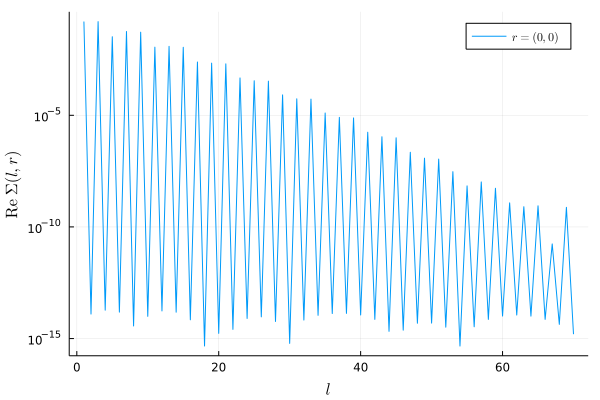

In [10]:
# Sigma(l, r): (L, nr)
srl = fit(smpl_tau, srt, dim=1)
@assert size(srl) == (L, nr)

plot(abs.(srl[:,1]), label=latexstring("r=(0,0)"), xlabel=latexstring("l"), ylabel=latexstring("\\mathrm{Re}~\\Sigma(l, r)"), yaxis=:log)

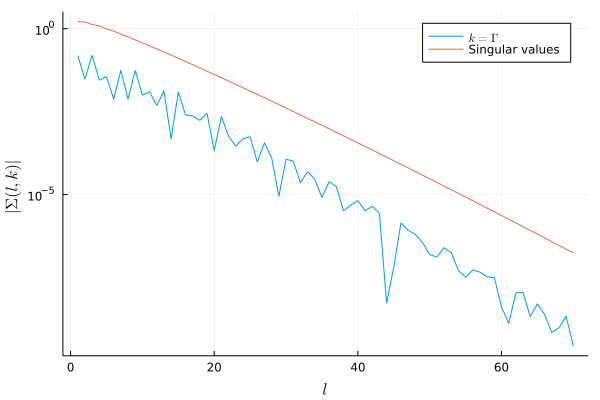

In [11]:
# Sigma(l, k): (L, nk)
srl = reshape(srl, L, kps...)
skl = ifft(srl, [2,3]) * nk
skl = reshape(skl, L, kps...)

plot(
    [abs.(skl[:,1,1]), basis.s], xlabel=latexstring("l"), ylabel=latexstring("|\\Sigma(l, k)|"), yaxis=:log,
    label=[latexstring("k=\\Gamma") "Singular values"]
)

## Step 6
Evaluate the self-energy on arbitrary frequencies/times

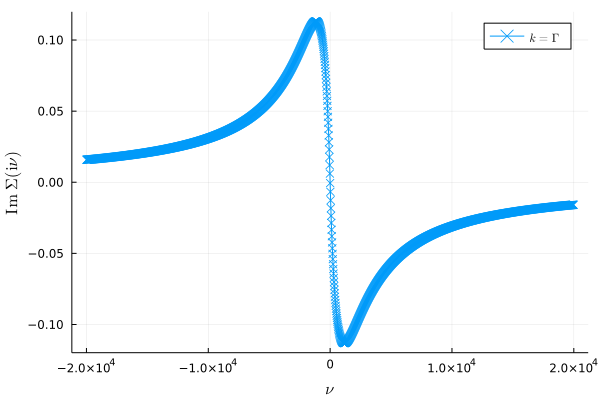

In [12]:
# Note: fermioic frequences must be represented by odd integers
my_freqs = 20 .* collect(-1000:999) .+ 1
#my_freqs = smpl_matsu.sampling_points
uhat = basis.uhat(my_freqs)
@tensor res[w,I,J] := uhat[l,w] * skl[l,I,J]

plot(my_freqs, imag(res[:,1,1]), label=latexstring("k=\\Gamma"),
    marker=:x, xlabel=latexstring("\\nu"), ylabel=latexstring("\\mathrm{Im}~\\Sigma(\\mathrm{i}\\nu)"))